<a href="https://colab.research.google.com/github/dgg32/ml_pycaret/blob/main/pycaret_tutorial_binary_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
!pip install pycaret

In [28]:
from pycaret.utils import enable_colab
enable_colab()

Colab mode enabled.




For this tutorial we will use a dataset from UCI called Default of Credit Card Clients Dataset. This dataset contains information on default payments, demographic factors, credit data, payment history, and billing statements of credit card clients in Taiwan from April 2005 to September 2005. There are 24,000 samples and 25 features. Short descriptions of each column are as follows:

    ID: ID of each client
    LIMIT_BAL: Amount of given credit in NT dollars (includes individual and family/supplementary credit)
    SEX: Gender (1=male, 2=female)
    EDUCATION: (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)
    MARRIAGE: Marital status (1=married, 2=single, 3=others)
    AGE: Age in years
    PAY_0 to PAY_6: Repayment status by n months ago (PAY_0 = last month ... PAY_6 = 6 months ago) (Labels: -1=pay duly, 1=payment delay for one month, 2=payment delay for two months, ... 8=payment delay for eight months, 9=payment delay for nine months and above)
    BILL_AMT1 to BILL_AMT6: Amount of bill statement by n months ago ( BILL_AMT1 = last_month .. BILL_AMT6 = 6 months ago)
    PAY_AMT1 to PAY_AMT6: Amount of payment by n months ago ( BILL_AMT1 = last_month .. BILL_AMT6 = 6 months ago)
    default: Default payment (1=yes, 0=no) Target Column

Dataset Acknowledgement:

Lichman, M. (2013). UCI Machine Learning Repository. Irvine, CA: University of California, School of Information and Computer Science.

The original dataset and data dictionary can be found here.


In [29]:
from pycaret.datasets import get_data
dataset = get_data("credit")

LIMIT_BAL  SEX  EDUCATION  MARRIAGE  ...  PAY_AMT4  PAY_AMT5  PAY_AMT6  default
0      20000    2          2         1  ...       0.0       0.0       0.0        1
1      90000    2          2         2  ...    1000.0    1000.0    5000.0        0
2      50000    2          2         1  ...    1100.0    1069.0    1000.0        0
3      50000    1          2         1  ...    9000.0     689.0     679.0        0
4      50000    1          1         2  ...    1000.0    1000.0     800.0        0

[5 rows x 24 columns]

In [30]:
dataset.shape

(24000, 24)

In order to demonstrate the predict_model() function on unseen data, a sample of 1200 records has been withheld from the original dataset to be used for predictions. This should not be confused with a train/test split as this particular split is performed to simulate a real life scenario. Another way to think about this is that these 1200 records are not available at the time when the machine learning experiment was performed.

In [31]:
data = dataset.sample(frac=0.95, random_state=786)
data_unseen = dataset.drop(data.index)
data.reset_index (inplace=True, drop=True)
data_unseen.reset_index(inplace=True, drop=True)
print (f"Data for modeling {data.shape}")
print (f"Data for prediction {data_unseen.shape}")

Data for modeling (22800, 24)
Data for prediction (1200, 24)


# Setting up Environment in PyCaret



The setup() function initializes the environment in pycaret and creates the transformation pipeline to prepare the data for modeling and deployment. setup() must be called before executing any other function in pycaret. It takes two mandatory parameters: a pandas dataframe and the name of the target column. All other parameters are optional and are used to customize the pre-processing pipeline (we will see them in later tutorials).

When setup() is executed, PyCaret's inference algorithm will automatically infer the data types for all features based on certain properties. The data type should be inferred correctly but this is not always the case. To account for this, PyCaret displays a table containing the features and their inferred data types after setup() is executed. If all of the data types are correctly identified enter can be pressed to continue or quit can be typed to end the expriment. Ensuring that the data types are correct is of fundamental importance in PyCaret as it automatically performs a few pre-processing tasks which are imperative to any machine learning experiment. These tasks are performed differently for each data type which means it is very important for them to be correctly configured.

In later tutorials we will learn how to overwrite PyCaret's infered data type using the numeric_features and categorical_features parameters in setup().


In [32]:
from pycaret.classification import *

In [33]:
exp_clf101 = setup(data = data, target = "default", session_id = 123)

Description             Value
0                               session_id               123
1                                   Target           default
2                              Target Type            Binary
3                            Label Encoded        0: 0, 1: 1
4                            Original Data       (22800, 24)
5                           Missing Values             False
6                         Numeric Features                14
7                     Categorical Features                 9
8                         Ordinal Features             False
9                High Cardinality Features             False
10                 High Cardinality Method              None
11                   Transformed Train Set       (15959, 88)
12                    Transformed Test Set        (6841, 88)
13                      Shuffle Train-Test              True
14                     Stratify Train-Test             False
15                          Fold Generator   StratifiedKFold
16                             Fold Number                10
17                                CPU Jobs                -1
18                                 Use GPU             False
19                          Log Experiment             False
20                         Experiment Name  clf-default-name
21                                     USI              3ed6
22                         Imputation Type            simple
23          Iterative Imputation Iteration              None
24                         Numeric Imputer              mean
25      Iterative Imputation Numeric Model              None
26                     Categorical Imputer          constant
27  Iterative Imputation Categorical Model              None
28           Unknown Categoricals Handling    least_frequent
29                               Normalize             False
30                        Normalize Method              None
31                          Transformation             False
32                   Transformation Method              None
33                                     PCA             False
34                              PCA Method              None
35                          PCA Components              None
36                     Ignore Low Variance             False
37                     Combine Rare Levels             False
38                    Rare Level Threshold              None
39                         Numeric Binning             False
40                         Remove Outliers             False
41                      Outliers Threshold              None
42                Remove Multicollinearity             False
43             Multicollinearity Threshold              None
44                              Clustering             False
45                    Clustering Iteration              None
46                     Polynomial Features             False
47                       Polynomial Degree              None
48                    Trignometry Features             False
49                    Polynomial Threshold              None
50                          Group Features             False
51                       Feature Selection             False
52            Features Selection Threshold              None
53                     Feature Interaction             False
54                           Feature Ratio             False
55                   Interaction Threshold              None
56                           Fix Imbalance             False
57                    Fix Imbalance Method             SMOTE

# Comparing all models

Comparing all models to evaluate performance is the recommended starting point for modeling once the setup is completed (unless you exactly know what kind of model you need, which is often not the case). This function trains all models in the model library and scores them using stratified cross validation for metric evaluation. The output prints a score grid that shows average Accuracy, AUC, Recall, Precision, F1, Kappa, and MCC accross the folds (10 by default) along with training times.

In [34]:
best_model = compare_models()

Model  Accuracy     AUC  Recall   Prec.  \
ridge                    Ridge Classifier    0.8254  0.0000  0.3637  0.6913   
lda          Linear Discriminant Analysis    0.8247  0.7634  0.3755  0.6794   
gbc          Gradient Boosting Classifier    0.8226  0.7789  0.3551  0.6806   
ada                  Ada Boost Classifier    0.8221  0.7697  0.3505  0.6811   
catboost              CatBoost Classifier    0.8218  0.7758  0.3669  0.6685   
lightgbm  Light Gradient Boosting Machine    0.8210  0.7750  0.3609  0.6679   
rf               Random Forest Classifier    0.8199  0.7598  0.3663  0.6601   
xgboost         Extreme Gradient Boosting    0.8160  0.7561  0.3629  0.6391   
et                 Extra Trees Classifier    0.8092  0.7377  0.3677  0.6047   
lr                    Logistic Regression    0.7814  0.6410  0.0003  0.1000   
knn                K Neighbors Classifier    0.7547  0.5939  0.1763  0.3719   
dt               Decision Tree Classifier    0.7293  0.6147  0.4104  0.3878   
svm                   SVM - Linear Kernel    0.7277  0.0000  0.1017  0.1671   
qda       Quadratic Discriminant Analysis    0.4795  0.5267  0.6105  0.2493   
nb                            Naive Bayes    0.3760  0.6442  0.8845  0.2441   

              F1   Kappa     MCC  TT (Sec)  
ridge     0.4764  0.3836  0.4122     0.053  
lda       0.4835  0.3884  0.4132     0.299  
gbc       0.4664  0.3725  0.4010     5.771  
ada       0.4626  0.3690  0.3983     1.328  
catboost  0.4736  0.3771  0.4018    13.249  
lightgbm  0.4683  0.3721  0.3977     0.394  
rf        0.4707  0.3727  0.3965     2.968  
xgboost   0.4626  0.3617  0.3829     5.576  
et        0.4571  0.3497  0.3657     2.262  
lr        0.0006  0.0003  0.0034     0.932  
knn       0.2388  0.1145  0.1259     0.942  
dt        0.3986  0.2242  0.2245     0.374  
svm       0.0984  0.0067  0.0075     0.476  
qda       0.3336  0.0435  0.0520     0.160  
nb        0.3826  0.0608  0.1207     0.051

Two simple words of code (not even a line) have trained and evaluated over 15 models using cross validation. The score grid printed above highlights the highest performing metric for comparison purposes only. The grid by default is sorted using 'Accuracy' (highest to lowest) which can be changed by passing the sort parameter. For example compare_models(sort = 'Recall') will sort the grid by Recall instead of Accuracy. If you want to change the fold parameter from the default value of 10 to a different value then you can use the fold parameter. For example compare_models(fold = 5) will compare all models on 5 fold cross validation. Reducing the number of folds will improve the training time. By default, compare_models return the best performing model based on default sort order but can be used to return a list of top N models by using n_select parameter.

In [35]:
print (best_model)

RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=123, solver='auto',
                tol=0.001)


# create a model



create_model is the most granular function in PyCaret and is often the foundation behind most of the PyCaret functionalities. As the name suggests this function trains and evaluates a model using cross validation that can be set with fold parameter. The output prints a score grid that shows Accuracy, AUC, Recall, Precision, F1, Kappa and MCC by fold.

For the remaining part of this tutorial, we will work with the below models as our candidate models. The selections are for illustration purposes only and do not necessarily mean they are the top performing or ideal for this type of data.

    Decision Tree Classifier ('dt')
    K Neighbors Classifier ('knn')
    Random Forest Classifier ('rf')

There are 18 classifiers available in the model library of PyCaret. To see list of all classifiers either check the docstring or use models function to see the library.


In [36]:
models()

Name  ...  Turbo
ID                                         ...       
lr                    Logistic Regression  ...   True
knn                K Neighbors Classifier  ...   True
nb                            Naive Bayes  ...   True
dt               Decision Tree Classifier  ...   True
svm                   SVM - Linear Kernel  ...   True
rbfsvm                SVM - Radial Kernel  ...  False
gpc           Gaussian Process Classifier  ...  False
mlp                        MLP Classifier  ...  False
ridge                    Ridge Classifier  ...   True
rf               Random Forest Classifier  ...   True
qda       Quadratic Discriminant Analysis  ...   True
ada                  Ada Boost Classifier  ...   True
gbc          Gradient Boosting Classifier  ...   True
lda          Linear Discriminant Analysis  ...   True
et                 Extra Trees Classifier  ...   True
xgboost         Extreme Gradient Boosting  ...   True
lightgbm  Light Gradient Boosting Machine  ...   True
catboost              CatBoost Classifier  ...   True

[18 rows x 3 columns]

## Decision Tree Classifier

In [37]:
dt = create_model("dt")

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.7343  0.6257  0.4327  0.4005  0.4160  0.2444  0.2447
1       0.7325  0.6277  0.4384  0.3984  0.4175  0.2443  0.2448
2       0.7431  0.6282  0.4241  0.4146  0.4193  0.2544  0.2544
3       0.7274  0.6151  0.4155  0.3856  0.4000  0.2240  0.2242
4       0.7187  0.6054  0.4040  0.3691  0.3858  0.2038  0.2042
5       0.7187  0.6014  0.3897  0.3656  0.3773  0.1958  0.1960
6       0.7206  0.6128  0.4212  0.3760  0.3973  0.2162  0.2168
7       0.7331  0.5986  0.3610  0.3830  0.3717  0.2024  0.2026
8       0.7206  0.6045  0.3983  0.3707  0.3840  0.2036  0.2038
9       0.7442  0.6272  0.4195  0.4148  0.4171  0.2533  0.2533
Mean    0.7293  0.6147  0.4104  0.3878  0.3986  0.2242  0.2245
SD      0.0092  0.0112  0.0218  0.0174  0.0173  0.0218  0.0218

In [38]:
print (dt)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=123, splitter='best')


## K Neighbors Classifier

In [39]:
knn = create_model("knn")

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.7469  0.6020  0.1920  0.3545  0.2491  0.1128  0.1204
1       0.7550  0.5894  0.2092  0.3883  0.2719  0.1402  0.1500
2       0.7506  0.5883  0.1576  0.3459  0.2165  0.0923  0.1024
3       0.7419  0.5818  0.1519  0.3136  0.2046  0.0723  0.0790
4       0.7563  0.5908  0.1490  0.3611  0.2110  0.0954  0.1085
5       0.7550  0.5997  0.1748  0.3720  0.2378  0.1139  0.1255
6       0.7638  0.5890  0.1891  0.4125  0.2593  0.1413  0.1565
7       0.7613  0.6240  0.1633  0.3904  0.2303  0.1163  0.1318
8       0.7619  0.5988  0.1862  0.4037  0.2549  0.1356  0.1500
9       0.7549  0.5756  0.1897  0.3771  0.2524  0.1246  0.1351
Mean    0.7547  0.5939  0.1763  0.3719  0.2388  0.1145  0.1259
SD      0.0065  0.0126  0.0191  0.0279  0.0214  0.0214  0.0230

In [40]:
rf = create_model("rf")

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.8133  0.7673  0.3610  0.6269  0.4582  0.3551  0.3749
1       0.8239  0.7615  0.3782  0.6735  0.4844  0.3882  0.4117
2       0.8258  0.7708  0.3467  0.7076  0.4654  0.3756  0.4098
3       0.8177  0.7605  0.3725  0.6436  0.4719  0.3710  0.3913
4       0.8208  0.7642  0.3725  0.6599  0.4762  0.3780  0.4006
5       0.8283  0.7638  0.3954  0.6866  0.5018  0.4070  0.4297
6       0.8127  0.7647  0.3582  0.6250  0.4554  0.3522  0.3721
7       0.8283  0.7390  0.3553  0.7168  0.4751  0.3861  0.4202
8       0.8108  0.7496  0.3610  0.6146  0.4549  0.3496  0.3678
9       0.8176  0.7565  0.3621  0.6462  0.4641  0.3645  0.3867
Mean    0.8199  0.7598  0.3663  0.6601  0.4707  0.3727  0.3965
SD      0.0062  0.0089  0.0131  0.0335  0.0139  0.0172  0.0202

Notice that the mean score of all models matches with the score printed in compare_models(). This is because the metrics printed in the compare_models() score grid are the average scores across all CV folds. Similar to compare_models(), if you want to change the fold parameter from the default value of 10 to a different value then you can use the fold parameter. For Example: create_model('dt', fold = 5) will create a Decision Tree Classifier using 5 fold stratified CV.

# Tune a Model

When a model is created using the create_model() function it uses the default hyperparameters to train the model. In order to tune hyperparameters, the tune_model() function is used. This function automatically tunes the hyperparameters of a model using Random Grid Search on a pre-defined search space. The output prints a score grid that shows Accuracy, AUC, Recall, Precision, F1, Kappa, and MCC by fold for the best model. To use the custom search grid, you can pass custom_grid parameter in the tune_model function (see 9.2 KNN tuning below). 

In [41]:
tuned_dt = tune_model(dt)

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.8177  0.7475  0.3095  0.6835  0.4260  0.3355  0.3728
1       0.8289  0.7711  0.3381  0.7375  0.4637  0.3782  0.4190
2       0.8208  0.7377  0.2894  0.7266  0.4139  0.3305  0.3796
3       0.8252  0.7580  0.3152  0.7333  0.4409  0.3563  0.4010
4       0.8195  0.7545  0.3095  0.6968  0.4286  0.3398  0.3794
5       0.8271  0.7509  0.3438  0.7186  0.4651  0.3769  0.4134
6       0.8195  0.7488  0.3123  0.6943  0.4308  0.3415  0.3801
7       0.8246  0.7529  0.2980  0.7482  0.4262  0.3446  0.3957
8       0.8195  0.7241  0.3123  0.6943  0.4308  0.3415  0.3801
9       0.8188  0.7378  0.3075  0.6903  0.4254  0.3362  0.3751
Mean    0.8222  0.7483  0.3136  0.7123  0.4352  0.3481  0.3896
SD      0.0037  0.0122  0.0156  0.0219  0.0159  0.0161  0.0158

In [42]:
print (tuned_dt)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=6, max_features=1.0, max_leaf_nodes=None,
                       min_impurity_decrease=0.002, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=123, splitter='best')


In [43]:
import numpy as np
tuned_knn = tune_model(knn, custom_grid= {"n_neighbors": np.arange(0, 50, 1)})

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.7813  0.6482  0.0372  0.5000  0.0693  0.0402  0.0876
1       0.7807  0.6436  0.0315  0.4783  0.0591  0.0330  0.0759
2       0.7744  0.6563  0.0315  0.3333  0.0576  0.0206  0.0403
3       0.7845  0.6589  0.0659  0.5610  0.1179  0.0754  0.1345
4       0.7826  0.6645  0.0315  0.5500  0.0596  0.0368  0.0903
5       0.7794  0.6477  0.0544  0.4634  0.0974  0.0539  0.0961
6       0.7826  0.6278  0.0630  0.5238  0.1125  0.0688  0.1214
7       0.7751  0.6702  0.0372  0.3611  0.0675  0.0278  0.0523
8       0.7813  0.6409  0.0630  0.5000  0.1120  0.0662  0.1146
9       0.7881  0.6426  0.0661  0.6389  0.1198  0.0822  0.1548
Mean    0.7810  0.6501  0.0482  0.4910  0.0873  0.0505  0.0968
SD      0.0039  0.0119  0.0148  0.0861  0.0255  0.0206  0.0338

In [44]:
print(tuned_knn)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=42, p=2,
                     weights='uniform')


In [45]:
tuned_rf = tune_model(rf)

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.8158  0.7508  0.3181  0.6647  0.4302  0.3363  0.3689
1       0.8283  0.7675  0.3295  0.7419  0.4563  0.3719  0.4152
2       0.8139  0.7337  0.3181  0.6529  0.4277  0.3321  0.3628
3       0.8246  0.7588  0.3095  0.7347  0.4355  0.3514  0.3976
4       0.8170  0.7567  0.3438  0.6557  0.4511  0.3539  0.3805
5       0.8258  0.7506  0.3324  0.7205  0.4549  0.3676  0.4067
6       0.8170  0.7530  0.3324  0.6629  0.4427  0.3474  0.3771
7       0.8221  0.7507  0.3381  0.6901  0.4538  0.3621  0.3951
8       0.8177  0.7201  0.2980  0.6933  0.4168  0.3286  0.3699
9       0.8207  0.7484  0.3132  0.6987  0.4325  0.3439  0.3831
Mean    0.8203  0.7490  0.3233  0.6915  0.4402  0.3495  0.3857
SD      0.0045  0.0126  0.0135  0.0310  0.0129  0.0140  0.0165



By default, tune_model optimizes Accuracy but this can be changed using optimize parameter. For example: tune_model(dt, optimize = 'AUC') will search for the hyperparameters of a Decision Tree Classifier that results in the highest AUC instead of Accuracy. For the purposes of this example, we have used the default metric Accuracy only for the sake of simplicity. Generally, when the dataset is imbalanced (such as the credit dataset we are working with) Accuracy is not a good metric for consideration. The methodology behind selecting the right metric to evaluate a classifier is beyond the scope of this tutorial but if you would like to learn more about it, you can click here to read an article on how to choose the right evaluation metric.

Metrics alone are not the only criteria you should consider when finalizing the best model for production. Other factors to consider include training time, standard deviation of kfolds etc. As you progress through the tutorial series we will discuss those factors in detail at the intermediate and expert levels. For now, let's move forward considering the Tuned Random Forest Classifier tuned_rf, as our best model for the remainder of this tutorial.


## AUC Plot

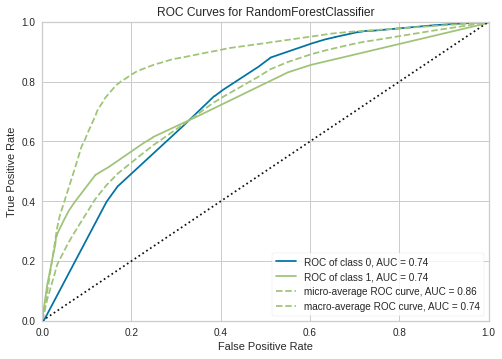

In [46]:
plot_model(tuned_rf, plot = 'auc')

## Precision-Recall Curve

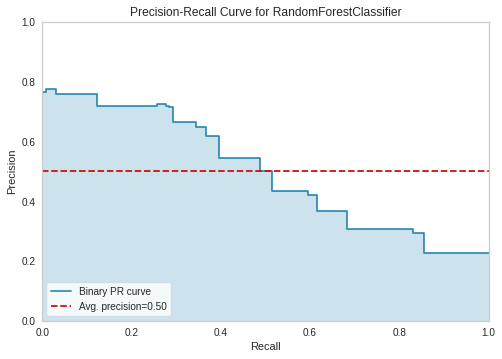

In [47]:
plot_model (tuned_rf, plot = "pr")

## Feature Importance Plot

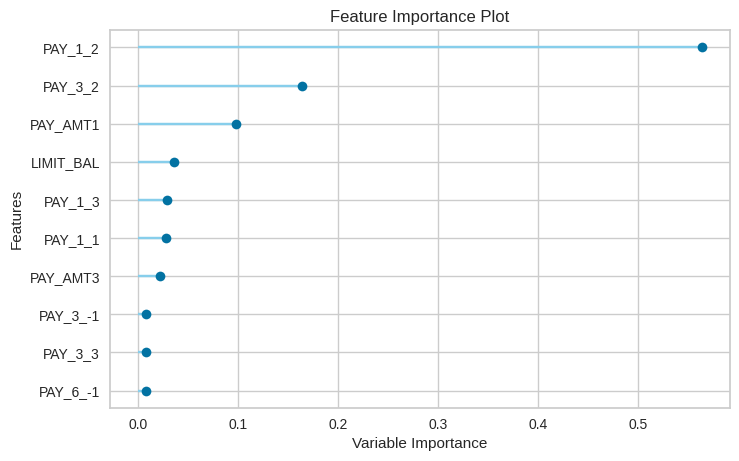

In [49]:
plot_model (tuned_rf, plot="feature")

## Confusion Matrix

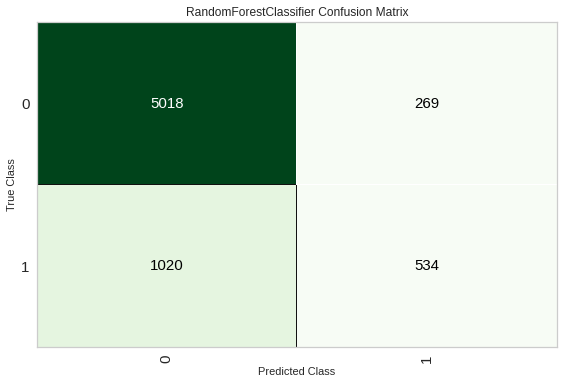

In [50]:
plot_model (tuned_rf, plot="confusion_matrix")

Another way to analyze the performance of models is to use the evaluate_model() function which displays a user interface for all of the available plots for a given model. It internally uses the plot_model() function.

In [51]:
evaluate_model(tuned_rf)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

# Predict on test / hold-out Sample

Before finalizing the model, it is advisable to perform one final check by predicting the test/hold-out set and reviewing the evaluation metrics. If you look at the information grid in Section 6 above, you will see that 30% (6,841 samples) of the data has been separated out as test/hold-out sample. All of the evaluation metrics we have seen above are cross validated results based on the training set (70%) only. Now, using our final trained model stored in the tuned_rf variable we will predict against the hold-out sample and evaluate the metrics to see if they are materially different than the CV results.

This is still not the data_unseen though.

In [52]:
predict_model(tuned_rf)

Model  Accuracy     AUC  ...      F1  Kappa     MCC
0  Random Forest Classifier    0.8116  0.7407  ...  0.4531  0.353  0.3811

[1 rows x 8 columns]

LIMIT_BAL   AGE  BILL_AMT1  BILL_AMT2  ...  PAY_6_8  default  Label   Score
0       80000.0  29.0     6228.0      589.0  ...      0.0        0      0  0.8452
1      180000.0  30.0   149069.0   152317.0  ...      0.0        1      0  0.9201
2      100000.0  26.0    18999.0    23699.0  ...      0.0        0      0  0.9201
3      500000.0  36.0      396.0     1043.0  ...      0.0        0      0  0.8452
4      190000.0  47.0   192493.0   193297.0  ...      0.0        0      0  0.9201
...         ...   ...        ...        ...  ...      ...      ...    ...     ...
6836   120000.0  44.0    75294.0    76465.0  ...      0.0        1      0  0.5649
6837    50000.0  26.0    47095.0    48085.0  ...      0.0        0      0  0.8394
6838    80000.0  39.0    46401.0    39456.0  ...      0.0        0      0  0.8452
6839   200000.0  33.0    50612.0    10537.0  ...      0.0        0      0  0.7548
6840   210000.0  35.0    25806.0     5861.0  ...      0.0        0      0  0.8452

[6841 rows x 91 columns]



The accuracy on test/hold-out set is 0.8135 compared to 0.8225 achieved on the tuned_rf CV results (in section 9.3 above). This is not a significant difference. If there is a large variation between the test/hold-out and CV results, then this would normally indicate over-fitting but could also be due to several other factors and would require further investigation. In this case, we will move forward with finalizing the model and predicting on unseen data (the 5% that we had separated in the beginning and never exposed to PyCaret).

(TIP : It's always good to look at the standard deviation of CV results when using create_model().)


# Finalize Model for Deployment

Model finalization is the last step in the experiment. A normal machine learning workflow in PyCaret starts with setup(), followed by comparing all models using compare_models() and shortlisting a few candidate models (based on the metric of interest) to perform several modeling techniques such as hyperparameter tuning, ensembling, stacking etc. This workflow will eventually lead you to the best model for use in making predictions on new and unseen data. The finalize_model() function fits the model onto the complete dataset including the test/hold-out sample (30% in this case). The purpose of this function is to train the model on the complete dataset before it is deployed in production.

In [54]:
final_rf = finalize_model(tuned_rf)

In [55]:
print (final_rf)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight={},
                       criterion='entropy', max_depth=5, max_features=1.0,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0002, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=-1, oob_score=False, random_state=123, verbose=0,
                       warm_start=False)


Caution: One final word of caution. Once the model is finalized using finalize_model(), the entire dataset including the test/hold-out set is used for training. As such, if the model is used for predictions on the hold-out set after finalize_model() is used, the information grid printed will be misleading as you are trying to predict on the same data that was used for modeling. In order to demonstrate this point only, we will use final_rf under predict_model() to compare the information grid with the one above in section 11.

In [56]:
predict_model(final_rf)

Model  Accuracy     AUC  ...      F1   Kappa     MCC
0  Random Forest Classifier    0.8184  0.7526  ...  0.4692  0.3736  0.4053

[1 rows x 8 columns]

LIMIT_BAL   AGE  BILL_AMT1  BILL_AMT2  ...  PAY_6_8  default  Label   Score
0       80000.0  29.0     6228.0      589.0  ...      0.0        0      0  0.8051
1      180000.0  30.0   149069.0   152317.0  ...      0.0        1      0  0.9121
2      100000.0  26.0    18999.0    23699.0  ...      0.0        0      0  0.8051
3      500000.0  36.0      396.0     1043.0  ...      0.0        0      0  0.9121
4      190000.0  47.0   192493.0   193297.0  ...      0.0        0      0  0.9121
...         ...   ...        ...        ...  ...      ...      ...    ...     ...
6836   120000.0  44.0    75294.0    76465.0  ...      0.0        1      1  0.5013
6837    50000.0  26.0    47095.0    48085.0  ...      0.0        0      0  0.8603
6838    80000.0  39.0    46401.0    39456.0  ...      0.0        0      0  0.8051
6839   200000.0  33.0    50612.0    10537.0  ...      0.0        0      0  0.8051
6840   210000.0  35.0    25806.0     5861.0  ...      0.0        0      0  0.9121

[6841 rows x 91 columns]

# Predict on unseen data



The predict_model() function is also used to predict on the unseen dataset. The only difference from section 11 above is that this time we will pass the data_unseen parameter. data_unseen is the variable created at the beginning of the tutorial and contains 5% (1200 samples) of the original dataset which was never exposed to PyCaret. (see section 5 for explanation)


In [57]:
unseen_predictions = predict_model(final_rf, data = data_unseen)
unseen_predictions.head()

LIMIT_BAL  SEX  EDUCATION  MARRIAGE  ...  PAY_AMT6  default  Label   Score
0     100000    2          2         2  ...    1542.0        0      0  0.8051
1     380000    1          2         2  ...    8251.0        0      0  0.9121
2     200000    2          2         1  ...    1395.0        0      0  0.8051
3     200000    1          1         1  ...    5000.0        1      1  0.7911
4     240000    1          1         2  ...     924.0        0      0  0.9121

[5 rows x 26 columns]

The Label and Score columns are added onto the data_unseen set. Label is the prediction and score is the probability of the prediction. Notice that predicted results are concatenated to the original dataset while all the transformations are automatically performed in the background. You can also check the metrics on this since you have actual target column default available. To do that we will use pycaret.utils module. See example below:

In [58]:
from pycaret.utils import check_metric
check_metric(unseen_predictions.default, unseen_predictions.Label, "Accuracy")

0.8167

# Saving the model
We have now finished the experiment by finalizing the tuned_rf model which is now stored in final_rf variable. We have also used the model stored in final_rf to predict data_unseen. This brings us to the end of our experiment, but one question is still to be asked: What happens when you have more new data to predict? Do you have to go through the entire experiment again? The answer is no, PyCaret's inbuilt function save_model() allows you to save the model along with entire transformation pipeline for later use.

In [59]:
save_model(final_rf, 'Final RF Model')

Transformation Pipeline and Model Succesfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[], target='default',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_stra...
                  RandomForestClassifier(bootstrap=False, ccp_alpha=0.0,
                                         class_weight={}, criterion='entropy',
                                         max_depth=5, max_features=1.0,
                                         max_leaf_

# Loading the saved model

In [60]:
saved_final_rf = load_model("Final RF Model")

Transformation Pipeline and Model Successfully Loaded


In [61]:
new_prediction = predict_model(saved_final_rf, data = data_unseen)

In [62]:
new_prediction.head()

LIMIT_BAL  SEX  EDUCATION  MARRIAGE  ...  PAY_AMT6  default  Label   Score
0     100000    2          2         2  ...    1542.0        0      0  0.8051
1     380000    1          2         2  ...    8251.0        0      0  0.9121
2     200000    2          2         1  ...    1395.0        0      0  0.8051
3     200000    1          1         1  ...    5000.0        1      1  0.7911
4     240000    1          1         2  ...     924.0        0      0  0.9121

[5 rows x 26 columns]

Notice that the results of unseen_predictions and new_prediction are identical.

In [63]:
from pycaret.utils import check_metric
check_metric(new_prediction.default, new_prediction.Label, 'Accuracy')

0.8167